# import packages

In [1]:
import rmsp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../python_modules/')  # Defining the path to my modules
from conditional_distributions import ConditionalMG

# load data

In [2]:
# Loading data
data = pd.read_csv('wl_semisyn_bivariate.csv')
# data_orig['z'] = 0

# Converting Pandas Dataframe into a RMSP Point Data
data = rmsp.PointData(data, x='x', y="y")
data.drop('x1_shift', axis=1, inplace=True)
data.rename(columns={'x1':'var1', 'tg':'var2'}, inplace=True)

type(data)

rmsp.core.point.PointData

In [3]:
data

,x,y,var1,var2
0,1.0,1.0,2.403560,1.199623
1,10.0,1.0,3.541236,3.309053
2,20.0,1.0,2.452675,1.763755
3,30.0,1.0,5.053473,4.298008
4,40.0,1.0,4.753003,4.612557
...,...,...,...,...
832,220.0,300.0,4.387805,4.187833
833,230.0,300.0,3.621725,3.686127
834,240.0,300.0,3.831457,3.841583
835,250.0,300.0,3.841273,3.759928


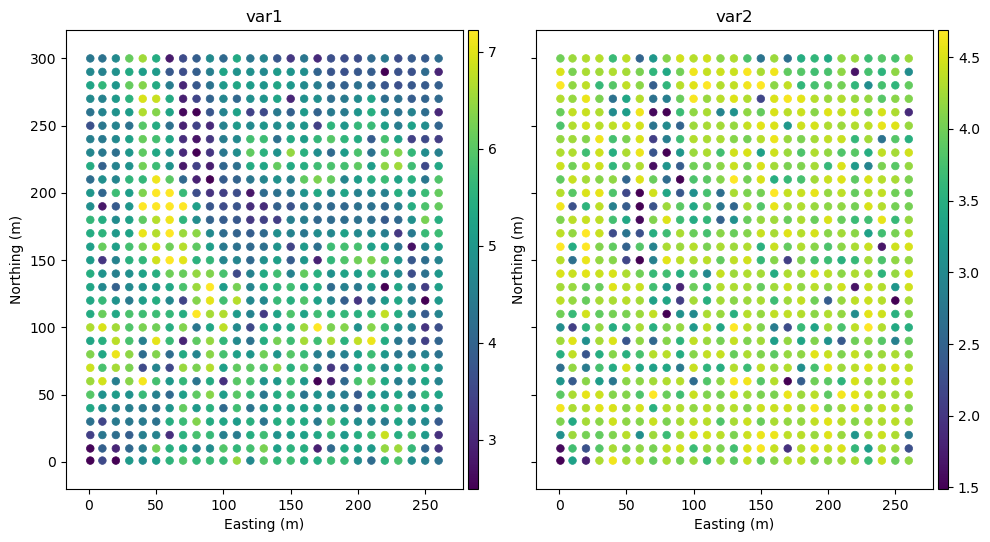

In [4]:
fig, axes = plt.subplots(1,2, figsize=(10, 7), sharey=True)
for var, ax in zip(['var1', 'var2'], axes):
    data.sectionplot(var, ax=ax, s=30)
fig.tight_layout()

# sub-sampling and splitting data

In [5]:
# Define threshold on the reference variable
thr_var = 'var1'
threshold = data[thr_var].quantile(0.50)

# fractions to select below and above threshold
frac_above = 0.60
frac_below = 0.40

# Select samples above and below the median threshold
samples_above_threshold = data[data[thr_var] > threshold]
samples_below_threshold = data[(data[thr_var] < threshold)]

# Sample subsets
complete_set_above = samples_above_threshold.sample(frac=frac_above, random_state=42)
complete_set_below = samples_below_threshold.sample(frac=frac_below, random_state=42)

# Combine subsets
complete_set = pd.concat([complete_set_above, complete_set_below])

# Remaining samples (excluding complete set) go to missing set
missing_set = data.drop(complete_set.index)

# Split the "complete" subset into validation and modeling subsets
valid_set = complete_set.sample(frac=0.15, random_state=42)
model_set = complete_set.drop(valid_set.index)

# Create flags in the main dataframe
data['missing'] = 0
data['valid'] = 0
data['model'] = 0
data.loc[missing_set.index, 'missing'] = 1
data.loc[valid_set.index,   'valid']   = 1
data.loc[model_set.index,   'model']   = 1

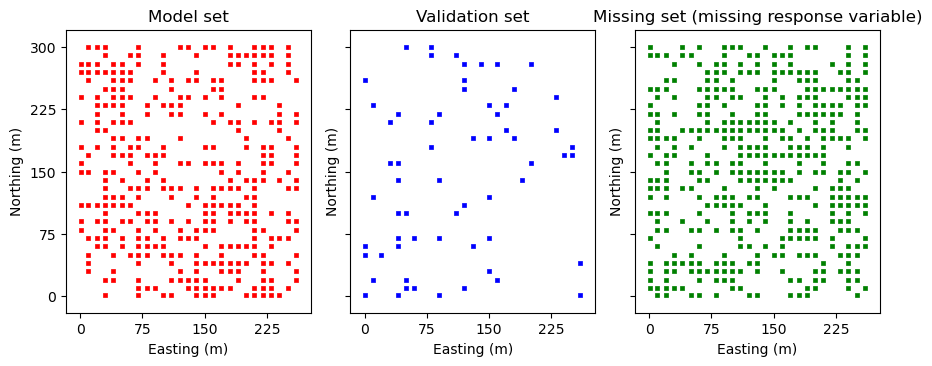

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(9, 9), sharey=True, sharex=True)

# Plot samples
model_set.sectionplot(None, ax=axes[0], color='red', s=8, marker='s', title='Model set')
valid_set.sectionplot(None, ax=axes[1], color='blue', s=8, marker='s', title='Validation set')
missing_set.sectionplot(None, ax=axes[2], color='green', s=8, marker='s', title='Missing set (missing response variable)')

fig.tight_layout()

In [7]:
# Function to compute empirical CDF
def empirical_cdf(data):
    sorted_data = np.sort(data)  # Sort the data
    cdf = np.linspace(1/len(sorted_data), 1, len(sorted_data))  # Generate CDF values
    return sorted_data, cdf

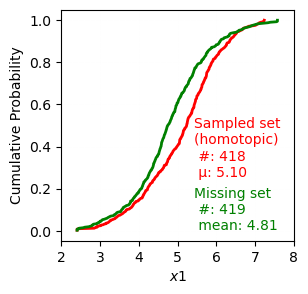

In [8]:
from matplotlib.lines import Line2D

# Compute CDFs
x_complete, cdf_complete = empirical_cdf(complete_set['var1'])
x_missing, cdf_missing = empirical_cdf(missing_set['var1'])

# Plot CDFs
plt.figure(figsize=(3, 3))
plt.plot(x_complete, cdf_complete, linewidth=2, color='red')
plt.plot(x_missing, cdf_missing, linewidth=2, color='green')

# Build legend
labels = [
    f"Sampled set\n(homotopic) \n #: {len(x_complete)}\n μ: {x_complete.mean():.2f}",
    f"Missing set \n #: {len(x_missing)}\n mean: {x_missing.mean():.2f}"
]
# Use dummy invisible handles
handles = [plt.Line2D([], [], color='none'), plt.Line2D([], [], color='none')]

leg = plt.legend(handles, labels, loc=(0.38, 0.01), frameon=False)

# Set text colors
leg.get_texts()[0].set_color('red')
leg.get_texts()[1].set_color('green')

# Transparent legend background
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

# Other definitions
plt.xlabel("$\mathit{x1}$")
plt.xticks(np.arange(2.0, 9.0, 1))
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle='--', alpha=0.01)
plt.show()

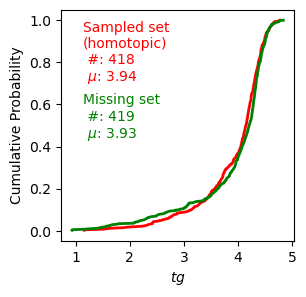

In [9]:
# Compute CDFs
x_complete, cdf_complete = empirical_cdf(complete_set['var2'])
x_missing, cdf_missing = empirical_cdf(missing_set['var2'])

# Plot CDFs
plt.figure(figsize=(3, 3))
plt.plot(x_complete, cdf_complete, linewidth=2, color='red')
plt.plot(x_missing, cdf_missing, linewidth=2, color='green')

# Build legend
labels = [
    f'Sampled set\n(homotopic)\n #: {len(x_complete)}\n $\mu$: {x_complete.mean():.2f}',
    f'Missing set \n #: {len(x_missing)}\n $\mu$: {x_missing.mean():.2f}'
]

# Invisible handles (so only text appears)
handles = [plt.Line2D([], [], color='none'),
           plt.Line2D([], [], color='none')]

leg = plt.legend(handles, labels, loc=(-0.10, 0.40), frameon=False)

# Apply colors to legend text
leg.get_texts()[0].set_color('red')
leg.get_texts()[1].set_color('green')

# Transparent background (extra safety)
leg.get_frame().set_facecolor('none')
leg.get_frame().set_edgecolor('none')

# Other definitions
plt.xlabel("$\mathit{tg}$")
plt.xticks(np.arange(1.0, 6.0, 1))
plt.ylabel("Cumulative Probability")
plt.grid(True, linestyle='--', alpha=0.01)
plt.show()


Text(0.05, 0.95, 'Sampled set\n(homotopic)')

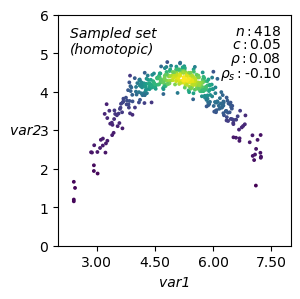

In [10]:
fig = complete_set.scatplots(
    ['var2', 'var1'],
    s=3,
    figsize=(3, 3),
    num_sample=1000,
    stats='all',
    stats_loc=(0.96, 0.65),
    lims={'var1': (2, 8)}
)

# Get the axis from the figure
ax = fig.axes[0]

# Make axis labels italic
ax.set_ylabel(ax.get_ylabel(), fontstyle='italic', labelpad=10)
ax.set_xlabel(ax.get_xlabel(), fontstyle='italic')

ax.text(0.05, 0.95, "Sampled set\n(homotopic)", transform=ax.transAxes,
        fontsize=10, fontstyle='italic', va='top', ha='left')

Text(0.05, 0.95, 'Missing set')

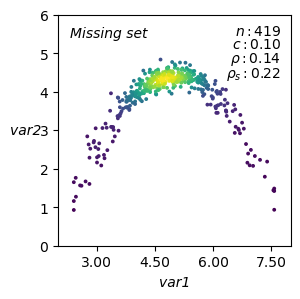

In [11]:
fig = missing_set.scatplots(
    ['var2', 'var1'],
    s=3,
    figsize=(3, 3),
    num_sample=1000,
    stats='all',
    stats_loc=(0.96, 0.65),
    lims={'var1': (2, 8)}
)

# Get the axis from the figure
ax = fig.axes[0]

# Make axis labels italic
ax.set_ylabel(ax.get_ylabel(), fontstyle='italic', labelpad=10)
ax.set_xlabel(ax.get_xlabel(), fontstyle='italic')

ax.text(0.05, 0.95, "Missing set", transform=ax.transAxes,
        fontsize=10, fontstyle='italic', va='top', ha='left')

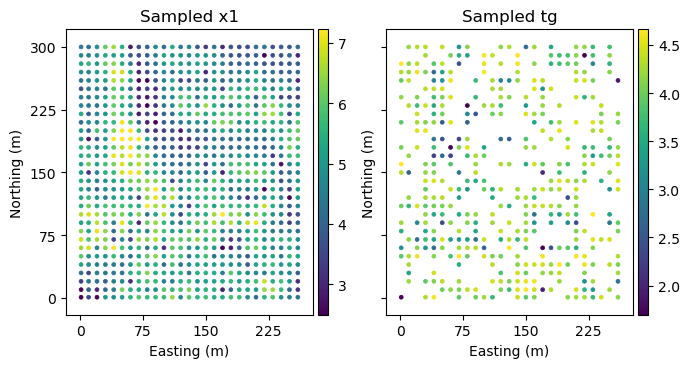

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharey=True)
data.sectionplot(var='var1', ax=axes[0], s=8, orient='xy', title='Sampled x1')
complete_set.sectionplot('var2', ax=axes[1], s=8, orient='xy', title='Sampled tg')
fig.tight_layout()

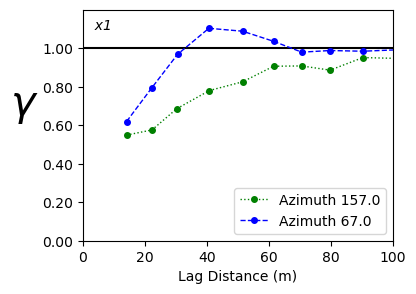

In [13]:
# defining lags for horizontal and vertical directions
lags_h = rmsp.Lags(10, 5, 15)

# defining searches for two directions
varsearches = [rmsp.ExpVarioSearch(157.0, 0.0, lags_h, azmtol=22, incltol=22.0, azmband=20, inclband=22),
                rmsp.ExpVarioSearch(67.0, 0.0, lags_h, azmtol=22, incltol=22.0, azmband=20, inclband=22)]

# calculating the experimental variograms
expvario_true = rmsp.ExpVario('traditional').calculate(data, 'var1', varsearches)

# plotting the experimental variograms
_, ax = expvario_true.plot(azm=157.0, incl=0.0,
    ls=":", ms=4, c="green", label="Azimuth 157.0", zorder=100, figsize=(4, 3), search_index=0, pairs_bar=False, pairs_c='lightsteelblue', xlim=(0,100)
)
expvario_true.plot_draw(ax, azm=67.0, incl=0.0, ls="--", ms=4, c="blue", label="Azimuth 67.0")


# Adding explanatory text
plt.text(
    x=0.01, y=0.90,  # Position as a fraction of the axes (0.05 = 5% from left/bottom)
    s="  x1",  # Explanatory text
    fontsize=10, fontstyle='italic', color='black', ha='left', va='bottom', transform=plt.gca().transAxes
)

# adding legend
_ = ax.legend(loc=4)

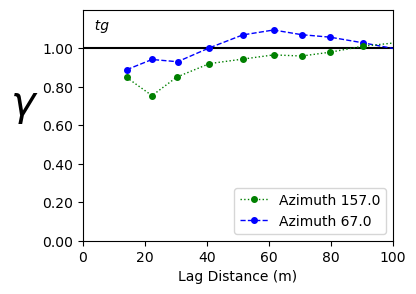

In [14]:
# calculating the experimental variograms
expvario_true = rmsp.ExpVario('traditional').calculate(data, 'var2', varsearches)

# plotting the experimental variograms
_, ax = expvario_true.plot(azm=157.0, incl=0.0,
    ls=":", ms=4, c="green", label="Azimuth 157.0", zorder=100, figsize=(4, 3), search_index=0, pairs_bar=False, pairs_c='lightsteelblue', xlim=(0,100)
)
expvario_true.plot_draw(ax, azm=67.0, incl=0.0, ls="--", ms=4, c="blue", label="Azimuth 67.0")


# Adding explanatory text
plt.text(
    x=0.01, y=0.90,  # Position as a fraction of the axes (0.05 = 5% from left/bottom)
    s="  tg",  # Explanatory text
    fontsize=10, fontstyle='italic', color='black', ha='left', va='bottom', transform=plt.gca().transAxes
)

# adding legend
_ = ax.legend(loc=4)